In [57]:
library(ggplot2)
library(dplyr)
library(MESS)
library(MLmetrics)
library(ggpubr)
library(ggpmisc)
library(ResourceSelection)

In [29]:
BASE.PATH <- './output/mult'

result_list <- list()

result <- NULL

for (d in list.files(BASE.PATH)) {
    
    if (grepl('GSE', d)) {
        
        path <- paste(BASE.PATH, d, 'inference', sep='/')
        
        i <- 1
        
        means <- list()
        
        values <- c()
        
        for (f in sort(list.files(path))) {
            
            if (grepl('valid', f)) {
                
                filename <- paste(path, f, sep='/')
                
                df <- read.table(filename, sep=',', header=T)
                
                colnames(df) <- c('dataset', 'y', 'y_hat')
                
                df$fold <- f
                df$dataset <- d
                
                if (is.null(result)) {
                    result <- df
                } else {
                    result <- rbind(result, df)
                }
            }
        }
    }
}

result$method <- 'MuLT'

head(result)

,dataset,y,y_hat,fold,method
,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,GSE135820,0,0.20834892,valid_0.csv,MuLT
2,GSE135820,0,0.10040507,valid_0.csv,MuLT
3,GSE135820,0,0.05900202,valid_0.csv,MuLT
4,GSE135820,0,0.08849602,valid_0.csv,MuLT
5,GSE135820,0,0.12070721,valid_0.csv,MuLT
6,GSE135820,0,0.16405699,valid_0.csv,MuLT


In [30]:
BASE.PATH <- './output/smla'

for (m in list.files(BASE.PATH)) {

    if (grepl('lightgbm', m)) {
        method <- 'LightGBM'
    } else {
        method <- toupper(m)
    }
    
    if (grepl('_', m))
        next
    
    path_ <- paste(BASE.PATH, m, sep='/')
    
    for (d in list.files(path_)) {

        if (grepl('GSE', d)) {

            path <- paste(path_, d, 'inference', sep='/')

            for (f in sort(list.files(path))) {

                if (grepl('valid', f)) {
                    
                    filename <- paste(path, f, sep='/')
                    
                    df <- read.table(filename, sep=',', header=T)
                    
                    colnames(df) <- c('dataset', 'y', 'y_hat')
                    
                    df$fold <- f
                    
                    df$dataset <- d
                    
                    df$method <- method

                    if (is.null(result)) {
                        result <- df
                    } else {
                        result <- rbind(result, df)
                    }
                }
            }
        }
    }
}

head(result)

,dataset,y,y_hat,fold,method
,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,GSE135820,0,0.20834892,valid_0.csv,MuLT
2,GSE135820,0,0.10040507,valid_0.csv,MuLT
3,GSE135820,0,0.05900202,valid_0.csv,MuLT
4,GSE135820,0,0.08849602,valid_0.csv,MuLT
5,GSE135820,0,0.12070721,valid_0.csv,MuLT
6,GSE135820,0,0.16405699,valid_0.csv,MuLT


In [31]:
r <- c()

for (i in seq(1, nrow(result))) {
    
    row = result[i,]
    y_hat = row$y_hat
    y = row$y
    r <- c(r, MLmetrics::LogLoss(y, y_hat))
}

result$logloss <- r

In [115]:
fit.dataset <- result
fit.dataset$residual <- fit.dataset$y - fit.dataset$y_hat

methods <- unique(fit.dataset$method)
datasets <- unique(fit.dataset$dataset)

datasets_ <- c()
methods_ <- c()
rs <- c()

for (d in datasets) {
    tmp <- fit.dataset[fit.dataset$dataset == d,]
    for (m in methods) {
        tmp_ <- tmp[tmp$method == m,]
        model <- lm(residual ~ y_hat, data=tmp_)
        datasets_ <- c(datasets_, d)
        methods_ <- c(methods_, m)
        rs <- c(rs, summary(model)$r.squared)
    }
}

rsquared.df <- data.frame(dataset=datasets_, method=methods_, rsquared=rs)

head(rsquared.df)

,dataset,method,rsquared
,<fct>,<fct>,<dbl>
1,GSE135820,MuLT,0.013050349
2,GSE135820,KNN,0.059300759
3,GSE135820,LightGBM,0.002199139
4,GSE135820,MLP,0.002406998
5,GSE135820,SVM,0.017290800
6,GSE68465,MuLT,0.014975416


In [119]:
for (d in datasets) {
    tmp <- fit.dataset[fit.dataset$dataset == d,]
    for (m in methods) {
        tmp_ <- tmp[tmp$method == m,]
        writeLines(paste(d, m))
        print(ks.test(tmp_$residual, 'pnorm'))
    }
}

GSE135820 MuLT

	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.32757, p-value < 2.2e-16
alternative hypothesis: two-sided

GSE135820 KNN


Warning message in ks.test(tmp_$residual, "pnorm"):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.31675, p-value < 2.2e-16
alternative hypothesis: two-sided

GSE135820 LightGBM


Warning message in ks.test(tmp_$residual, "pnorm"):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.32047, p-value < 2.2e-16
alternative hypothesis: two-sided

GSE135820 MLP

	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.39928, p-value < 2.2e-16
alternative hypothesis: two-sided

GSE135820 SVM


Warning message in ks.test(tmp_$residual, "pnorm"):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.38639, p-value < 2.2e-16
alternative hypothesis: two-sided

GSE68465 MuLT

	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.21995, p-value < 2.2e-16
alternative hypothesis: two-sided

GSE68465 KNN


Warning message in ks.test(tmp_$residual, "pnorm"):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.19295, p-value = 1.021e-14
alternative hypothesis: two-sided

GSE68465 LightGBM

	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.16323, p-value = 1.179e-10
alternative hypothesis: two-sided

GSE68465 MLP

	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.2677, p-value < 2.2e-16
alternative hypothesis: two-sided

GSE68465 SVM


Warning message in ks.test(tmp_$residual, "pnorm"):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.28668, p-value < 2.2e-16
alternative hypothesis: two-sided

GSE94873 MuLT


Warning message in ks.test(tmp_$residual, "pnorm"):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.25822, p-value < 2.2e-16
alternative hypothesis: two-sided

GSE94873 KNN


Warning message in ks.test(tmp_$residual, "pnorm"):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.19484, p-value < 2.2e-16
alternative hypothesis: two-sided

GSE94873 LightGBM

	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.19356, p-value < 2.2e-16
alternative hypothesis: two-sided

GSE94873 MLP

	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.28385, p-value < 2.2e-16
alternative hypothesis: two-sided

GSE94873 SVM


Warning message in ks.test(tmp_$residual, "pnorm"):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  tmp_$residual
D = 0.2818, p-value < 2.2e-16
alternative hypothesis: two-sided



`summarise()` has grouped output by 'method'. You can override using the `.groups` argument.

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



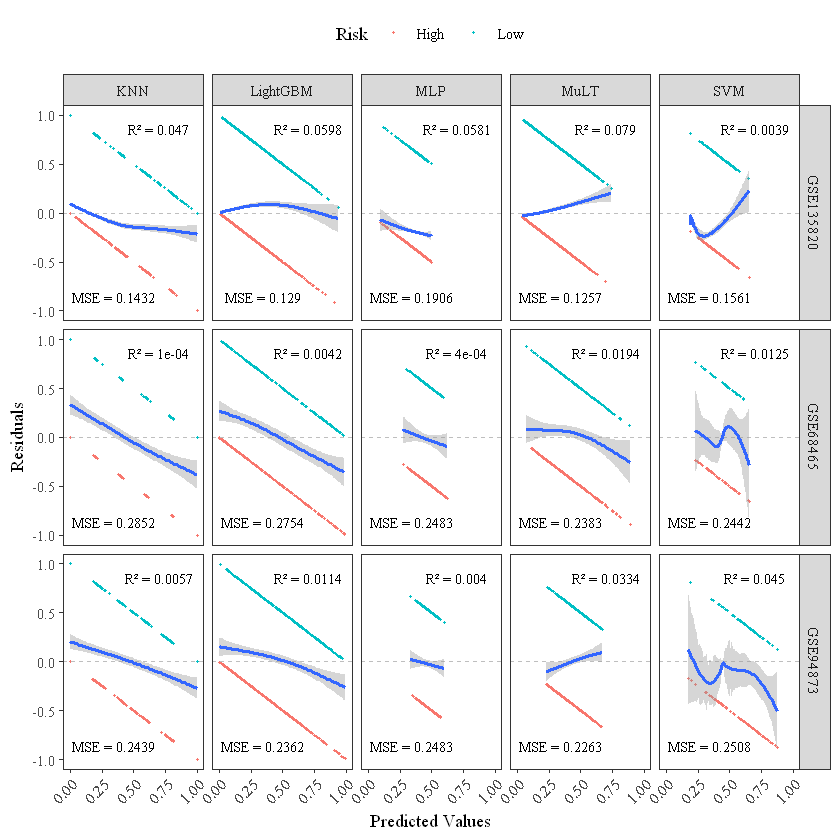

In [114]:
l <- result %>% group_by(method, dataset) %>% summarize(m = round(mean((y - y_hat)**2), 4))

p <- 
  ggplot(result, aes(y_hat, y - y_hat)) + 
  geom_point(aes(colour=as.factor(y)), size=.5) + 
  geom_hline(yintercept = 0, lty=2,col="grey") + 
  xlab('Predicted Values') + 
  ylab('Residuals') + 
  geom_smooth() +
  geom_label(aes(x=.35, y=-.86, label=paste0('MSE = ', l$m, sep='')), 
             data=l, inherit.aes=F, size=3, family='serif', fill=NA, label.size=NA, alpha=.65) +
  geom_label(aes(x=.7, y=.86, label=paste0('R²', ' = ',round(rsquared, digits=4))), 
             data=rsquared.df, inherit.aes=F, size=3, family='serif', fill=NA, label.size=NA, alpha=.65) +
  # stat_cor(size=2.5, output.type='latex') +
  # stat_regline_equation() +
  # stat_fit_glance(method = 'lm',
  #                     method.args = list(formula = formula),
  #                     geom = 'text',
  #                     aes(label = paste("P-value = ", signif(..p.value.., digits = 4), sep = ""))) +
  # stat_cor(label.y = .8, label.x= -2.5) +
  theme_bw() +
  scale_colour_discrete(name = "Risk", labels=c('High', 'Low')) +
  theme(text=element_text(size=11, family='serif'), 
        legend.position = "top", axis.text.x=element_text(angle=45, vjust=1, hjust=1),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank()) +
  facet_grid(dataset ~ method, scale='free_y')

ggsave('images/residuals_analysis.png', p, units='cm', width=18, height=12, dpi=600)

p

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



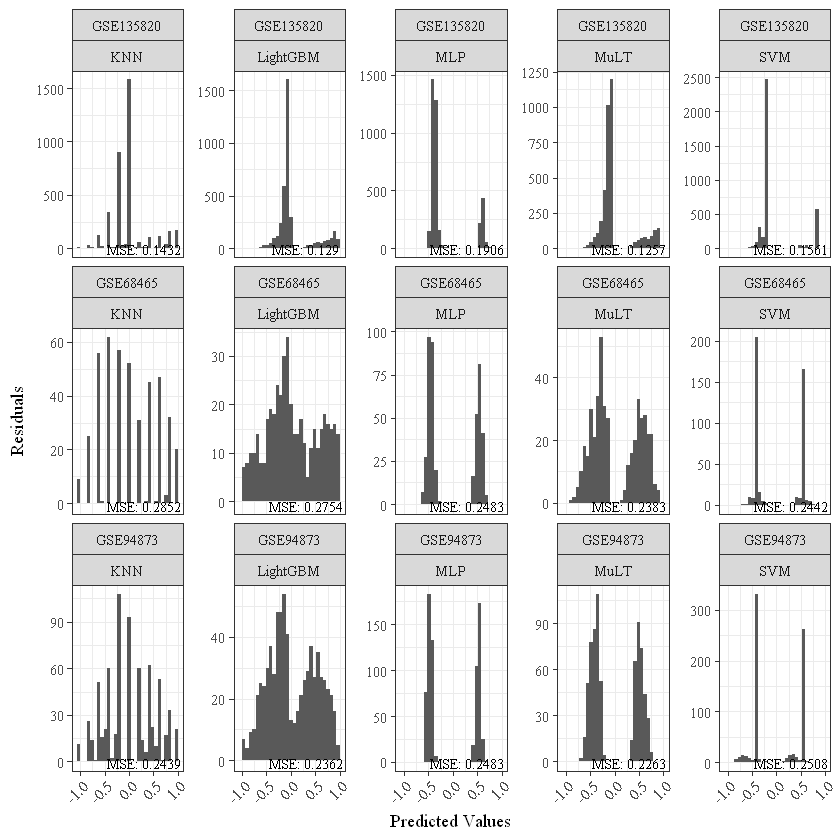

In [14]:
p <- 
  ggplot(result, aes(y - y_hat)) + 
  geom_histogram() + 
  xlab('Predicted Values') + 
  ylab('Residuals') + 
  geom_label(aes(x=.3, y=-.86, label=paste0('MSE: ', l$m, sep='')), 
             data=l, inherit.aes=F, size=3, family='serif', fill=NA, label.size=NA, alpha=.65) +
  theme_bw() +
  scale_colour_discrete(name = "Risk", labels=c('High', 'Low')) +
  theme(text=element_text(size=11, family='serif'), legend.position = "top", axis.text.x=element_text(angle=45, vjust=1, hjust=1)) +
  facet_wrap(dataset ~ method, scale='free_y', ncol=5)

ggsave('images/residuals_analysis_hist.png', p, units='cm', width=18, height=12, dpi=300)

p

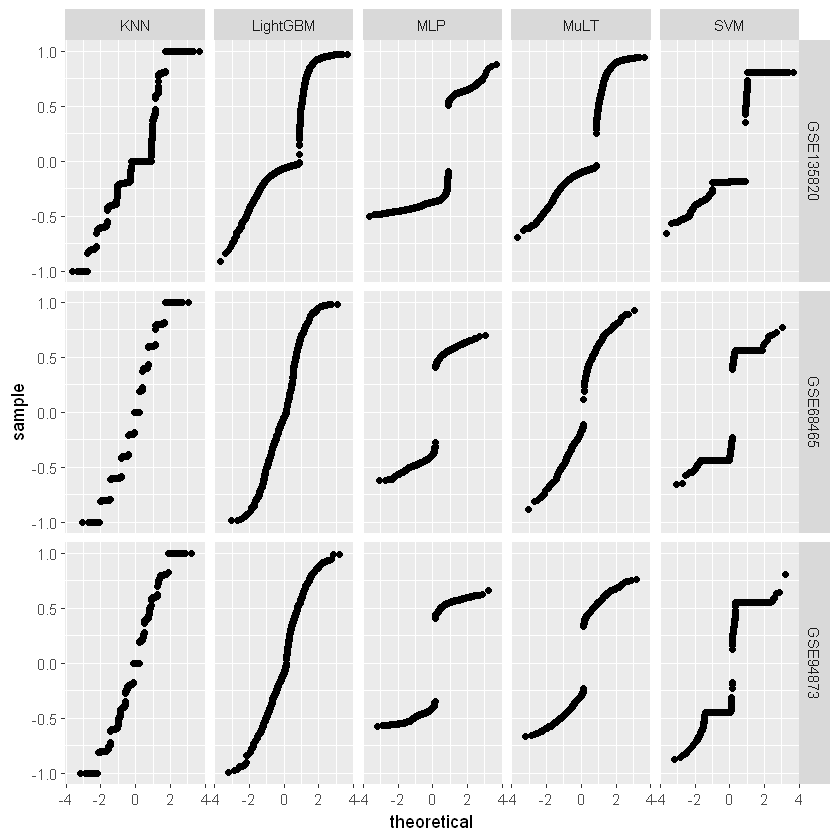

In [15]:
ggplot(result, aes(sample=y - y_hat)) + stat_qq() + facet_grid(dataset ~ method)

In [ ]:
for (m1 in unique(result$method)) {
    for (m2 in unique(result$method)) {
        if (m1 != m2 & m1 == 'MuLT') {

            s1 <- result[result$method == m1,]
            #s1$y_hat <- (s1$y_hat - min(s1$y_hat)) / (max(s1$y_hat) - min(s1$y_hat))
            s1$error <- (s1$y - s1$y_hat)**2

            s2 <- result[result$method == m2,]
            #s2$y_hat <- (s2$y_hat - min(s2$y_hat)) / (max(s2$y_hat) - min(s2$y_hat))
            s2$error <- (s2$y - s2$y_hat)**2

            print(paste('H1:', m1, '<', m2, ', p-value = ', t.test(s1$error, s2$error, alternative='l')$p.value))
        }
    }
}